In [255]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [256]:
import numpy as np
import pandas as pd

In [257]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [258]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_

In [259]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [260]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [261]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [262]:
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [263]:
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [264]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [265]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [266]:
engine.execute('SELECT * FROM Station LIMIT 3').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

In [267]:
engine.execute('SELECT * FROM Measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

# Exploratory Climate Analysis

In [268]:
#Design a query to retrieve the last 12 months of precipitation data
conn = engine.connect()
date_prcp = pd.read_sql("SELECT date, prcp FROM Measurement WHERE date between '2016-08-23' and '2017-08-23'", conn)
date_prcp = date_prcp.set_index('date')
date_prcp = date_prcp.sort_values(['date'])
date_prcp.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


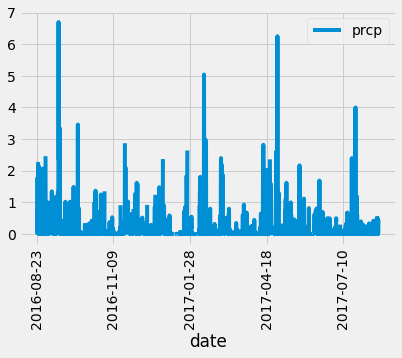

In [269]:
# plot the results
date_prcp.plot(rot=90)
plt.show()

In [270]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp.rename(columns = {'prcp' : 'precipitation'}).describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [271]:
stations_df = pd.read_sql("SELECT * FROM Station", conn)
stations_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [272]:
measurements_df = pd.read_sql("SELECT * FROM Measurement", conn)
measurements_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [273]:
#Design a query to calculate the total number of stations.

number_stations = session.query(Station).group_by(Station.station).count()
number_stations

9

In [274]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_station = session.query(Measurement.station,\
                 func.count(Measurement.station)).\
                 group_by(Measurement.station).\
                 order_by(func.count(Measurement.station).\
                 desc()).all()
# List the stations and the counts in descending order.
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [275]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(F"The average temperature for the most active station is {avg_temp}, with the minimum temp of {lowest_temp} and the highest temp of {highest_temp}.")

The average temperature for the most active station is [(71.66378066378067,)], with the minimum temp of [(54.0,)] and the highest temp of [(85.0,)].


In [288]:
# Choose the station with the highest number of temperature observations.
active_temp_station = session.query(Measurement.station,\
                 func.count(Measurement.tobs)).\
                 group_by(Measurement.station).\
                 order_by(func.count(Measurement.tobs).\
                 desc()).first()

active_temp_station

('USC00519281', 2772)

In [277]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram: use datetime.
import datetime as dt

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

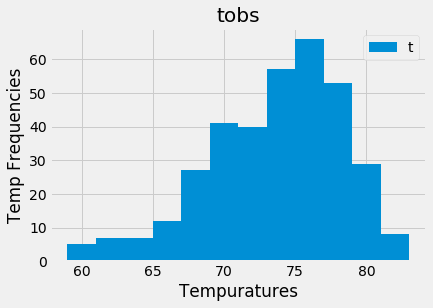

In [278]:
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)

lastyear_temps = session.query(Measurement.tobs).\
                 filter(and_(Measurement.station == 'USC00519281',\
                      Measurement.date >= query_date)).all()

lastyear_temps_df = pd.DataFrame(lastyear_temps)

lastyear_temps_df.hist(bins=12)
plt.ylabel('Temp Frequencies')
plt.xlabel('Tempuratures')
plt.legend('tobs')
plt.show()

## Bonus Challenge Assignment

In [279]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [280]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [281]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [282]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [283]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [284]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [285]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [286]:
# Plot the daily normals as an area plot with `stacked=False`
